In [1]:
import openpyxl
import pandas as pd
import numpy as np
import xgboost
import sklearn as sk
import matplotlib.pyplot as plt
import re # patteern matching

### 1. Gradient Boosting (XGBoost)
reference source: https://machinelearningmastery.com/xgboost-for-time-series-forecasting/ 

We need to first change the data into a more usable and compact form. This approach will be purely data driven, and will only use enrollment data from past Fall and Spring semesters to make next Fall semester's prediction.

XG Boost will be run on each core class independently rather than doing a multivariate approach for simplicity and perhaps better results?

Here we are first filtering the data for only classes we are interested in, and making a dictionary where the key is the course name and the value is another dictionary where the key is semester (Season + Year) and the value is the count of students in that class in that semester

In [2]:
# will augment 200 with 261 and 220 with 262 as they are comparable
cs_classes = ["CSCI261_Pass_C_Sem", "CSCI262_Pass_Sem", "CSCI200_Pass_C_Sem", "CSCI220_Pass_Sem", "CSCI306_Pass_Sem", "CSCI341_Pass_Sem", "CSCI358_Pass_Sem", "CSCI400_Pass_Sem", "CSCI406_Pass_Sem", "CSCI442_Pass_Sem"]
raw_data = pd.read_excel('CS Course Enrollment Data 030824.xlsx')
new_df = raw_data.loc[:, cs_classes] # filter for only classes we want
new_df.head()

# Create dictionaries of counts of students in each class for each semester listed
course_data = {}
# Iterate over each column in the DataFrame
for column in new_df.columns:
    # Get counts of unique values in the column
    value_counts = new_df[column].value_counts()
    
    # Convert value_counts Series to dictionary
    counts_dict = value_counts.to_dict()
    
    # Store the dictionary of counts for the column
    course_data[column] = counts_dict

# augment 200 with 261 and 220 with 262 and remove 261 and 262 from dictionary
# we will actually do it backwards - so 200/220 data is never accidently overwritten by the weirdness
# for example Fall 2022 CSCI 261 has 15 students somehow but we want to use enrollment nums for CSCI 200
# incredibly janky but who cares
course_data.get("CSCI261_Pass_C_Sem").update(course_data.get("CSCI200_Pass_C_Sem"))
course_data.get("CSCI262_Pass_Sem").update(course_data.get("CSCI220_Pass_Sem"))
# delete unnecessary columns
del course_data["CSCI200_Pass_C_Sem"]
del course_data["CSCI220_Pass_Sem"]

# rename 261 and 262 to 200 and 220 respectively
course_data["CSCI200_Pass_C_Sem"] = course_data.pop("CSCI261_Pass_C_Sem")
course_data["CSCI220_Pass_Sem"] = course_data.pop("CSCI262_Pass_Sem")
# Print the dictionaries for each column
# 2008 appears to be the earliest, and it goes up to Fall 2023
for course, counts_dict in course_data.items():
    print(f"Counts for {course}:")
    print(counts_dict)
    print()


Counts for CSCI306_Pass_Sem:
{'Spring 2022': 194, 'Fall 2022': 161, 'Fall 2020': 157, 'Fall 2021': 150, 'Fall 2023': 150, 'Spring 2021': 143, 'Spring 2023': 142, 'Spring 2020': 107, 'Fall 2019': 106, 'Spring 2019': 93, 'Fall 2018': 48, 'Spring 2018': 44, 'Fall 2017': 39, 'Fall 2016': 21, 'Spring 2017': 20, 'Fall 2015': 9, 'Spring 2016': 7, 'Fall 2013': 5, 'Fall 2014': 3, 'Spring 2015': 3, 'Spring 2013': 3, 'Spring 2012': 3, 'Spring 2008': 1}

Counts for CSCI341_Pass_Sem:
{'Spring 2022': 179, 'Fall 2021': 157, 'Spring 2021': 143, 'Spring 2023': 137, 'Fall 2020': 128, 'Spring 2020': 127, 'Fall 2023': 125, 'Fall 2022': 124, 'Fall 2019': 106, 'Spring 2019': 97, 'Fall 2018': 74, 'Spring 2018': 43, 'Fall 2017': 32, 'Spring 2017': 31, 'Spring 2016': 11, 'Summer 2023': 10, 'Fall 2016': 9, 'Fall 2015': 8, 'Spring 2015': 4, 'Fall 2014': 3, 'Fall 2012': 2, 'Spring 2012': 2, 'Fall 2011': 1, 'Spring 2013': 1, 'Spring 2014': 1, 'Fall 2013': 1}

Counts for CSCI358_Pass_Sem:
{'Spring 2023': 180, 'Fall

Next we want to sort the dictionaries in order to easily create our time-series data. We also remove the summer semesters from the data as enrollment numbers for summer are very different and likely do not vastly alter enrollment for the following Fall semester.

We will also create a version with only Fall semester data and compare the model trained on this to the one trained on both Fall and Spring data.

In [6]:
# Define a custom sorting key function
def custom_sort_key(s):
    # Extract the year from the string
    pattern = r'\b\d{4}\b'
    year = int(re.search(pattern, s).group())
    # Assign a sort order based on the season ("Spring" comes before "Fall")
    season_order = 0 if s.startswith("Spring") else 1
    # Combine the year and season order to create the sorting key
    return (year, season_order)

# sort dictionaries and remove summer semesters
for course, counts_dict in course_data.items():
    print(f"Counts for {course}:")
    counts_dict = dict(sorted(counts_dict.items(), key = lambda item: custom_sort_key(item[0])))
    summer = r'^Summer'
    counts_dict = {key: value for key, value in counts_dict.items() if not re.match(summer, key)}
    course_data[course] = counts_dict
    print(counts_dict)
    print()

# now remove spring semesters as well for Fall only version
course_data_fall = course_data
for course, counts_dict in course_data_fall.items():
    spring = r'^Spring'
    counts_dict = {key: value for key, value in counts_dict.items() if not re.match(spring, key)}
    course_data_fall[course] = counts_dict

Counts for CSCI306_Pass_Sem:
{'Fall 2013': 5, 'Fall 2014': 3, 'Fall 2015': 9, 'Fall 2016': 21, 'Fall 2017': 39, 'Fall 2018': 48, 'Fall 2019': 106, 'Fall 2020': 157, 'Fall 2021': 150, 'Fall 2022': 161, 'Fall 2023': 150}

Counts for CSCI341_Pass_Sem:
{'Fall 2011': 1, 'Fall 2012': 2, 'Fall 2013': 1, 'Fall 2014': 3, 'Fall 2015': 8, 'Fall 2016': 9, 'Fall 2017': 32, 'Fall 2018': 74, 'Fall 2019': 106, 'Fall 2020': 128, 'Fall 2021': 157, 'Fall 2022': 124, 'Fall 2023': 125}

Counts for CSCI358_Pass_Sem:
{'Fall 2011': 1, 'Fall 2012': 4, 'Fall 2014': 2, 'Fall 2015': 5, 'Fall 2016': 20, 'Fall 2017': 21, 'Fall 2018': 45, 'Fall 2019': 106, 'Fall 2020': 135, 'Fall 2021': 138, 'Fall 2022': 165, 'Fall 2023': 174}

Counts for CSCI400_Pass_Sem:
{'Fall 2012': 1, 'Fall 2013': 1, 'Fall 2014': 3, 'Fall 2015': 1, 'Fall 2016': 8, 'Fall 2017': 9, 'Fall 2018': 16, 'Fall 2019': 29, 'Fall 2020': 97, 'Fall 2021': 123, 'Fall 2022': 138, 'Fall 2023': 174}

Counts for CSCI406_Pass_Sem:
{'Fall 2013': 2, 'Fall 2014': 1,

We want to create separate data arrays using these dictionaries that can be fed easily into the algorithm. We will use a function to turn the time series data into supervised data. 

In [7]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	# n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = pd.concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

Now we need to define some functions to use walk-forward validation, as methods like cross validation won't work. We need to also create the model itself. - unsure how to actually use yet - wip

In [14]:
# fit an xgboost model and make a one step beyond data prediction
def xgboost_forecast(train, testX):
	train = np.asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1] # everything except last element in row
	# fit model
	model = xgboost.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict([testX])
	return yhat[0]

In [10]:
# array indexing sanity check
arr = np.array([[1,2,3], [4,5,6], [7,8,9]])
print(arr[:,:-1])
print(arr[:, -1])
print(arr[:-1,:])

[[1 2]
 [4 5]
 [7 8]]
[3 6 9]
[[1 2 3]
 [4 5 6]]


In [11]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :] # return rows 0 to n-n_test, ntest from n

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = xgboost_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = sk.metrics.mean_absolute_error(test[:, -1], predictions)
	return error, test[:, 1], predictions

Now we can try to actually make predictions. First we want to change the data into a supervised learning problem.

In [12]:
# instead of dictionary with dicts as values, lists as values
# we will also use this list as values version to construct an input for the next semester prediction
all_course_lists = {}
for course, column_count in course_data.items():
    value = (list(column_count.values()))
    all_course_lists.update({course: value})

# instead of dictionary with lists as values, use time series arrays 
all_course_data = {}
for course, column_count in all_course_lists.items():
    value = series_to_supervised(column_count, n_in = 5) # n_in = 5 will make each input to the next step a seq of 5 prev semesters
    all_course_data.update({course: value})

# for fall only version
############################################################################
fall_course_lists = {}
for course, column_count in course_data.items():
    value = (list(column_count.values()))
    fall_course_lists.update({course: value})

# instead of dictionary with lists as values, use time series arrays 
fall_course_data = {}
for course, column_count in all_course_lists.items():
    value = series_to_supervised(column_count, n_in = 5) # n_in = 5 will make each input to the next step a seq of 5 prev semesters
    fall_course_data.update({course: value})


>expected=255.0, predicted=236.0
>expected=289.0, predicted=255.0
>expected=173.0, predicted=289.0
>expected=191.0, predicted=173.0
>expected=302.0, predicted=191.0


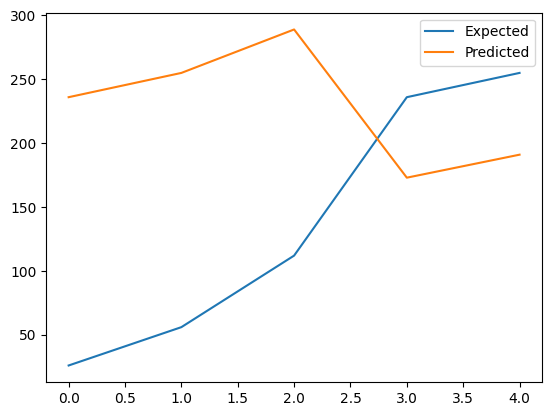

In [15]:
mae, y, yhat = walk_forward_validation(all_course_data.get("CSCI200_Pass_C_Sem"), 5)
# plot expected vs predicted
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()

In [54]:
#  As of now I am unsure of how to actually use the walk-forward validation to construct the best model
for course, data in all_course_data.items():
    trainX, trainy = data[:,:-1], data[:,-1]
    model = xgboost.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    model.fit(trainX, trainy)
    # construct an input for a new prediction
    row = all_course_lists.get(course)[-5:] # last 5 semesters to predict next semester
    # make a one-step prediction
    yhat = model.predict([np.asarray(row)])
    print(f'Course: {course}, Input: {row}, Predicted: {yhat[0]}')

Course: CSCI306_Pass_Sem, Input: [150, 194, 161, 142, 150], Predicted: 157.07337951660156
Course: CSCI341_Pass_Sem, Input: [157, 179, 124, 137, 125], Predicted: 134.13970947265625
Course: CSCI358_Pass_Sem, Input: [138, 149, 165, 180, 174], Predicted: 179.9986572265625
Course: CSCI400_Pass_Sem, Input: [123, 105, 138, 110, 174], Predicted: 127.151123046875
Course: CSCI406_Pass_Sem, Input: [114, 149, 158, 158, 147], Predicted: 157.7014923095703
Course: CSCI442_Pass_Sem, Input: [91, 156, 145, 188, 117], Predicted: 187.99879455566406
Course: CSCI200_Pass_C_Sem, Input: [173, 168, 191, 241, 302], Predicted: 277.6299133300781
Course: CSCI220_Pass_Sem, Input: [254, 131, 152, 155, 217], Predicted: 130.6915283203125
